<a href="https://colab.research.google.com/github/Pensive1881/jaguar-image-segmentation/blob/main/jaguar_unet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jaguar Segmentation with U-Net

This notebook trains a U-Net model for semantic segmentation of jaguar bodies using annotated data from CVAT.

Based on the u_net_tutorial.ipynb template.

## Mount Google Drive and Install Dependencies

**Important**: Run this cell first to mount your Google Drive!

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
!pip install torch torchvision tifffile torchmetrics==1.7.1 scikit-image matplotlib numpy pandas seaborn ipywidgets -q

print("\n✅ Google Drive mounted successfully!")
print("✅ Dependencies installed!")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00

✅ Google Drive mounted successfully!
✅ Dependencies installed!


## Import Libraries

In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import torchvision.transforms.functional as TF
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall
import torch.nn.functional as F
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Parse XML Annotations

The CVAT XML file contains RLE (Run-Length Encoding) encoded segmentation masks. We need to:
1. Parse the XML to get image names and mask data
2. Decode the RLE format into binary masks

In [3]:
def rle_decode(rle_string, width, height):
    """
    Decode RLE (Run-Length Encoding) string to binary mask.

    RLE format: alternating counts of 0s and 1s
    Example: "5, 10, 3" means 5 zeros, 10 ones, 3 zeros

    Args:
        rle_string: RLE encoded string with comma-separated integers
        width: Image width
        height: Image height

    Returns:
        Binary mask as numpy array (height, width)
    """
    # Parse RLE string
    rle_numbers = [int(x) for x in rle_string.split(',')]

    # Create flat mask
    mask_flat = np.zeros(width * height, dtype=np.uint8)

    # Decode RLE
    position = 0
    for i, count in enumerate(rle_numbers):
        if i % 2 == 1:  # Odd indices are 1s (foreground)
            mask_flat[position:position + count] = 1
        position += count

    # Reshape to image dimensions
    mask = mask_flat.reshape((height, width), order='F')
    return mask


def parse_cvat_xml(xml_path):
    """
    Parse CVAT XML annotation file.

    Args:
        xml_path: Path to XML file

    Returns:
        List of dicts with 'image_name', 'width', 'height', 'mask'
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    annotations = []

    for image in root.findall('image'):
        image_name = image.get('name')
        width = int(image.get('width'))
        height = int(image.get('height'))

        # Find mask element
        mask_elem = image.find('mask')
        if mask_elem is not None:
            rle_string = mask_elem.get('rle')
            if rle_string:
                # Decode RLE to binary mask
                mask = rle_decode(rle_string, width, height)

                annotations.append({
                    'image_name': image_name,
                    'width': width,
                    'height': height,
                    'mask': mask
                })

    return annotations

## Load Annotations

In [4]:
# Path to XML file and images directory
# IMPORTANT: Update these paths to match your Google Drive structure
xml_path = '/content/drive/MyDrive/jaguars_segmented_alex.xml'
images_dir = Path('/content/drive/MyDrive/fiftyone_images/cropped_body')

# Check if files exist
import os
if not os.path.exists(xml_path):
    print(f"❌ ERROR: XML file not found at: {xml_path}")
    print(f"\nPlease upload 'jaguars_segmented_alex.xml' to your Google Drive")
    print(f"Current Google Drive contents:")
    !ls -la /content/drive/MyDrive/ | head -20
else:
    print(f"✅ XML file found!")

if not images_dir.exists():
    print(f"\n❌ ERROR: Images directory not found at: {images_dir}")
    print(f"\nPlease upload your images to: {images_dir}")
else:
    print(f"✅ Images directory found!")
    print(f"   Number of images: {len(list(images_dir.glob('*.jpg')))}")

# Parse annotations
if os.path.exists(xml_path):
    annotations = parse_cvat_xml(xml_path)
    print(f"\n✅ Loaded {len(annotations)} annotated images")

    # Show first annotation info
    if annotations:
        print(f"\nFirst image: {annotations[0]['image_name']}")
        print(f"Dimensions: {annotations[0]['width']}x{annotations[0]['height']}")
        print(f"Mask shape: {annotations[0]['mask'].shape}")
        print(f"Positive pixels: {annotations[0]['mask'].sum()}")
else:
    print("\n⚠️  Cannot proceed without XML file. Please upload it to Google Drive first.")

✅ XML file found!
✅ Images directory found!
   Number of images: 3098

✅ Loaded 100 annotated images

First image: Alira_00291_cropped_body.jpg
Dimensions: 2585x1112
Mask shape: (1112, 2585)
Positive pixels: 957906


## Visualize Sample Images and Masks

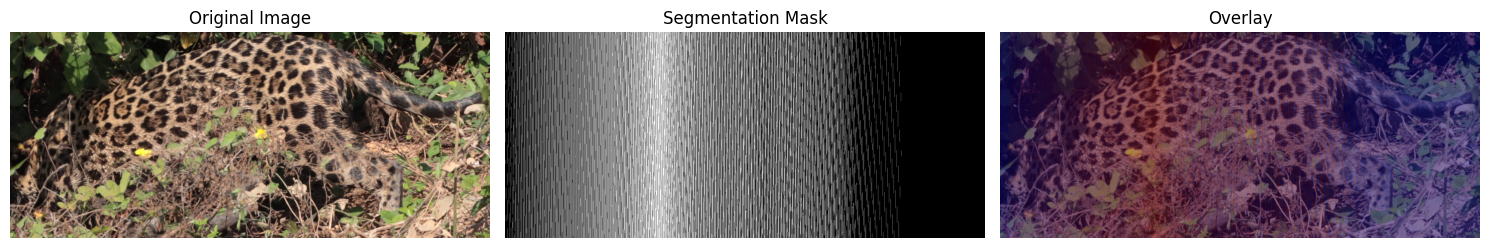

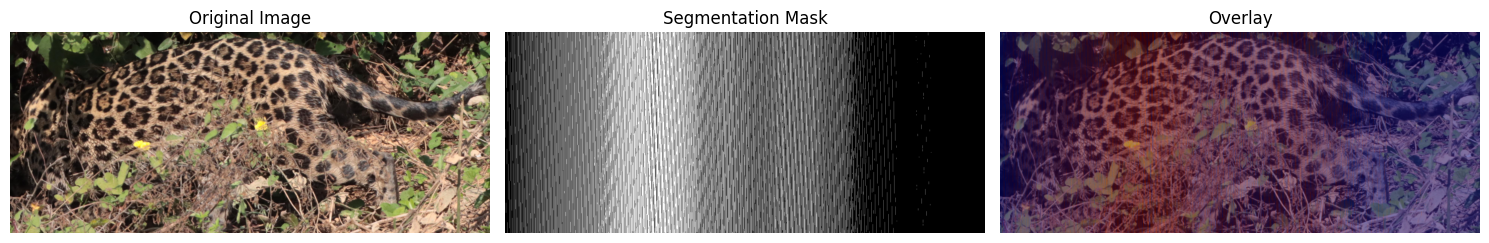

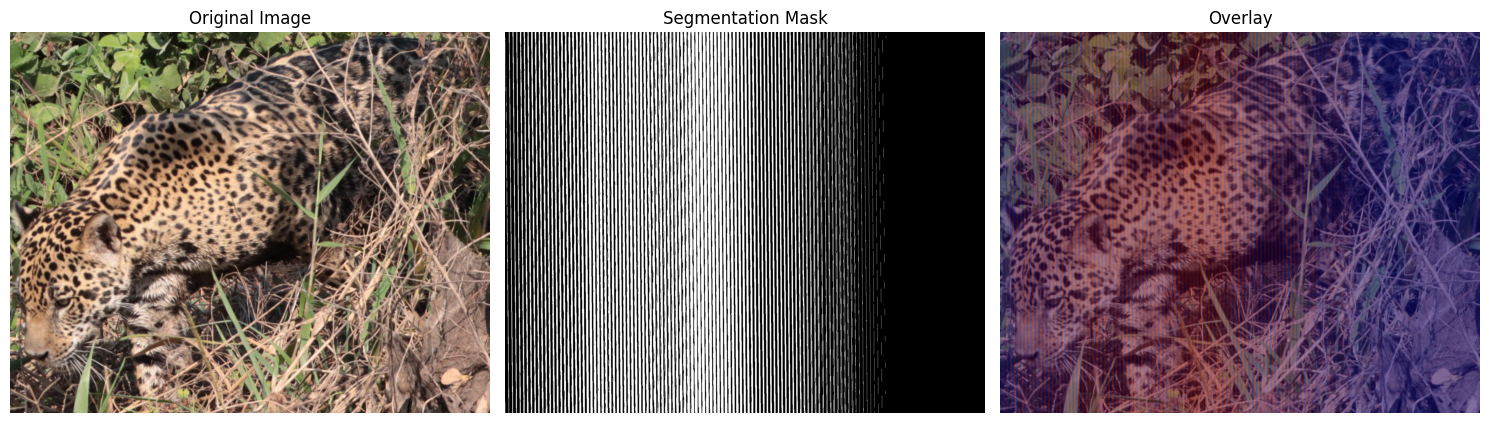

In [5]:
def visualize_sample(idx, annotations, images_dir):
    """
    Visualize a sample image and its mask.
    """
    ann = annotations[idx]
    image_path = images_dir / ann['image_name']

    if not image_path.exists():
        print(f"Image not found: {image_path}")
        return

    # Load image
    image = Image.open(image_path)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(ann['mask'], cmap='gray')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(image)
    axes[2].imshow(ann['mask'], alpha=0.5, cmap='jet')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize first few samples
for i in range(min(3, len(annotations))):
    visualize_sample(i, annotations, images_dir)

## Create PyTorch Dataset

We'll create a custom Dataset class similar to the tutorial, but adapted for jaguar images.

In [6]:
class JaguarSegmentationDataset(Dataset):
    """
    PyTorch Dataset for jaguar segmentation.
    """
    def __init__(self, annotations, images_dir, train_mean, train_std,
                 transform=None, target_size=(512, 512)):
        """
        Args:
            annotations: List of annotation dicts from parse_cvat_xml
            images_dir: Directory containing images
            train_mean: Mean for normalization
            train_std: Std for normalization
            transform: Optional transform function
            target_size: Resize images to this size (height, width)
        """
        self.annotations = annotations
        self.images_dir = Path(images_dir)
        self.train_mean = train_mean
        self.train_std = train_std
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = self.images_dir / ann['image_name']

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Resize image and mask to target size
        image = image.resize((self.target_size[1], self.target_size[0]), Image.BILINEAR)

        # Resize mask
        mask = Image.fromarray(ann['mask'])
        mask = mask.resize((self.target_size[1], self.target_size[0]), Image.NEAREST)
        mask = np.array(mask)

        # Convert to numpy arrays
        image = np.array(image)

        # Apply transforms if provided
        if self.transform:
            image, mask = self.transform(image, mask, self.train_mean, self.train_std)

        return image, mask


def train_transform(image, mask, train_mean, train_std):
    """
    Training transforms with data augmentation.
    """
    # Convert to PIL for transforms
    image = Image.fromarray(image)
    mask = Image.fromarray(mask.astype(np.uint8))

    # Random horizontal flip
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # Random vertical flip
    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)

    # Convert image to tensor and normalize
    image = TF.to_tensor(image)
    image = TF.normalize(image, train_mean, train_std)

    # Convert mask to tensor WITHOUT scaling (keep binary 0/1)
    mask = torch.from_numpy(np.array(mask, dtype=np.float32)).unsqueeze(0)

    return image, mask


def valid_transform(image, mask, train_mean, train_std):
    """
    Validation transforms (no augmentation).
    """
    # Convert to PIL
    image = Image.fromarray(image)

    # Convert image to tensor and normalize
    image = TF.to_tensor(image)
    image = TF.normalize(image, train_mean, train_std)

    # Convert mask to tensor WITHOUT scaling (keep binary 0/1)
    mask = torch.from_numpy(mask.astype(np.float32)).unsqueeze(0)

    return image, mask

## Prepare Data Splits

Split data into training and validation sets.

In [7]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Split into train and validation
validation_split = 0.2
dataset_size = len(annotations)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Random split
indices = np.arange(dataset_size)
np.random.shuffle(indices)
train_indices = indices[:train_size]
valid_indices = indices[train_size:]

train_annotations = [annotations[i] for i in train_indices]
valid_annotations = [annotations[i] for i in valid_indices]

print(f"Training samples: {len(train_annotations)}")
print(f"Validation samples: {len(valid_annotations)}")

Training samples: 80
Validation samples: 20


## Compute Dataset Statistics

Calculate mean and std for normalization.

In [8]:
# Compute mean and std from training images
print("Computing dataset statistics...")
pixel_values = []

for ann in tqdm(train_annotations[:20]):  # Sample first 20 for speed
    image_path = images_dir / ann['image_name']
    if image_path.exists():
        image = Image.open(image_path).convert('RGB')
        image = np.array(image) / 255.0  # Normalize to 0-1
        pixel_values.extend(image.flatten())

pixel_values = np.array(pixel_values)
train_mean = [pixel_values.mean()] * 3  # Same mean for all RGB channels
train_std = [pixel_values.std()] * 3     # Same std for all RGB channels

print(f"Train mean: {train_mean}")
print(f"Train std: {train_std}")

Computing dataset statistics...


100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


Train mean: [np.float64(0.31164084659769375), np.float64(0.31164084659769375), np.float64(0.31164084659769375)]
Train std: [np.float64(0.21818925620531596), np.float64(0.21818925620531596), np.float64(0.21818925620531596)]


## Create Datasets and DataLoaders

In [9]:
# Create datasets
train_dataset = JaguarSegmentationDataset(
    train_annotations,
    images_dir,
    train_mean,
    train_std,
    transform=train_transform,
    target_size=(512, 512)
)

valid_dataset = JaguarSegmentationDataset(
    valid_annotations,
    images_dir,
    train_mean,
    train_std,
    transform=valid_transform,
    target_size=(512, 512)
)

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")

Train batches: 20
Valid batches: 20


## Define U-Net Architecture

Same architecture from the tutorial.

In [10]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels // 2 + out_channels, out_channels)

    def forward(self, x, x1):
        x = self.up(x)
        # Handle size mismatch
        diffY = x1.size()[2] - x.size()[2]
        diffX = x1.size()[3] - x.size()[3]
        x = TF.pad(x, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2])
        # Concatenate skip connections
        x = torch.cat([x1, x], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """U-Net for semantic segmentation"""
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Training Functions

In [11]:
def validate_model(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    return epoch_val_loss


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the U-Net model"""
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in tqdm(range(num_epochs), desc="Training"):
        # Training phase
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        epoch_val_loss = validate_model(model, val_loader, criterion, device)
        val_losses.append(epoch_val_loss)

        # Save best model
        if epoch_val_loss < best_val_loss:
            print(f"\nEpoch {epoch+1}: Better weights found (val_loss: {epoch_val_loss:.4f})")
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    print('\nFinished Training')

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Plot losses
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

## Initialize Model and Training

In [12]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model (3 input channels for RGB, 1 output for binary segmentation)
model = UNet(n_channels=3, n_classes=1).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cuda
Model parameters: 13395329


## Train the Model

In [ ]:
# Train
num_epochs = 10
trained_model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

Training:  10%|█         | 1/10 [01:33<13:58, 93.19s/it]


Epoch 1: Better weights found (val_loss: 1.7643)


Training:  20%|██        | 2/10 [01:56<06:54, 51.80s/it]


Epoch 2: Better weights found (val_loss: 0.7120)


Training:  30%|███       | 3/10 [02:18<04:30, 38.62s/it]


Epoch 3: Better weights found (val_loss: 0.6507)


## Evaluate Model

Compute precision, recall, F1 scores at different thresholds.

In [ ]:
# Evaluation metrics
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
f1 = BinaryF1Score().to(device)

def evaluate_metrics(model, dataloader, threshold=0.5, device='cpu'):
    """Evaluate model with metrics"""
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    prec = precision(all_preds, all_labels).item()
    rec = recall(all_preds, all_labels).item()
    f1_score = f1(all_preds, all_labels).item()

    return prec, rec, f1_score

# Evaluate at different thresholds
print("Evaluating at different thresholds...")
thresholds = np.arange(0.1, 1.0, 0.1)
results = []

for thresh in thresholds:
    prec, rec, f1_score = evaluate_metrics(trained_model, valid_loader, threshold=thresh, device=device)
    results.append({'threshold': thresh, 'precision': prec, 'recall': rec, 'f1': f1_score})
    print(f"Threshold: {thresh:.2f} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1_score:.4f}")

# Find best threshold
best_result = max(results, key=lambda x: x['f1'])
print(f"\nBest threshold: {best_result['threshold']:.2f}")
print(f"Best F1 score: {best_result['f1']:.4f}")

## Visualize Predictions

In [ ]:
def visualize_predictions(model, dataset, idx, threshold=0.5, device='cpu'):
    """Visualize model predictions"""
    model.eval()

    # Get sample
    image, mask = dataset[idx]

    # Predict
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        logits = model(image_input)
        probs = torch.sigmoid(logits)
        pred_mask = (probs >= threshold).float()

    # Convert to numpy for visualization
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    # Denormalize
    image_np = image_np * np.array(train_std) + np.array(train_mean)
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.cpu().numpy().squeeze()
    pred_mask_np = pred_mask.cpu().numpy().squeeze()
    probs_np = probs.cpu().numpy().squeeze()

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(image_np)
    axes[0, 0].set_title('Input Image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask_np, cmap='gray')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(pred_mask_np, cmap='gray')
    axes[0, 2].set_title(f'Prediction (threshold={threshold:.2f})')
    axes[0, 2].axis('off')

    axes[1, 0].imshow(image_np)
    axes[1, 0].imshow(mask_np, alpha=0.5, cmap='jet')
    axes[1, 0].set_title('Ground Truth Overlay')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(probs_np, cmap='hot')
    axes[1, 1].set_title('Prediction Probabilities')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(image_np)
    axes[1, 2].imshow(pred_mask_np, alpha=0.5, cmap='jet')
    axes[1, 2].set_title('Prediction Overlay')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on validation set
for i in range(min(3, len(valid_dataset))):
    visualize_predictions(trained_model, valid_dataset, i, threshold=best_result['threshold'], device=device)

## Save Model

In [ ]:
# Save model
model_path = 'jaguar_unet_model.pth'
torch.save(trained_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

## Summary

This notebook demonstrated:
1. Parsing CVAT XML annotations with RLE-encoded masks
2. Creating a PyTorch Dataset for jaguar segmentation
3. Training a U-Net model for semantic segmentation
4. Evaluating the model at different thresholds
5. Visualizing predictions

Next steps:
- Try different architectures (ResNet encoder, attention mechanisms)
- Add more augmentations
- Fine-tune hyperparameters
- Use the model for inference on new jaguar images